In [75]:
import pandas as pd

# Load your Parquet file
file_path = "../data/curated/map_features.parquet"
df = pd.read_parquet(file_path)

# Check the first few rows to ensure it's loaded correctly
print(df.head())

property_types = df['property_type'].unique()

# Print the distinct property types
print(property_types)

                                              name postcode   latitude  \
0         10/668 Bourke Street, Melbourne VIC 3000     3000 -37.816589   
1  1001/20-26 Coromandel Place, Melbourne VIC 3000     3000 -37.813044   
2     1001/23 Mackenzie Street, Melbourne VIC 3000     3000 -37.807481   
3      1003/118 Russell Street, Melbourne VIC 3000     3000 -37.813500   
4      1003/220 Spencer Street, Melbourne VIC 3000     3000 -37.815695   

    longitude  distance_to_closest_school_km  distance_to_cbd  \
0  144.954206                          0.959            1.399   
1  144.969255                          1.096            1.299   
2  144.967331                          0.464            1.062   
3  144.969088                          1.024            1.226   
4  144.952913                          1.197            1.638   

             property_type beds   cost  House  flat  
0  Apartment / Unit / Flat    1  560.0  False  True  
1  Apartment / Unit / Flat    2  530.0  False  True  
2 

In [67]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession, functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

import warnings
warnings.filterwarnings("ignore") # suppress warnings

sdf = spark.read.parquet('../data/curated/properties_population.parquet')

# Dropping all duplicate rows

sdf1 = sdf.dropDuplicates()
 
print(sdf1)


+--------+------+------------------+---------+--------------------+----+-----+-------+--------------------+---------------+----------------------------+------------------------------+-----------------------+-------------------+-----------+---------------------------+----------+-----------------------------------+-------------------------------------+
|postcode|  cost|            suburb|furnished|       property_type|beds|baths|parking|              region|      lgaregion|total male population - 2021|total female population - 2021|total population - 2021|australian citizens|median rent|median family weekly income|median age|total region male population - 2022|total region female population - 2022|
+--------+------+------------------+---------+--------------------+----+-----+-------+--------------------+---------------+----------------------------+------------------------------+-----------------------+-------------------+-----------+---------------------------+----------+----------------

In [72]:
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("Add Column from One Parquet to Another").getOrCreate()

# Load the two Parquet files
file1_path = "../data/raw/distances.parquet"
file2_path = "../data/raw/property_data.parquet"

df1 = spark.read.parquet(file1_path)
df2 = spark.read.parquet(file2_path)

#df2.show()

df2_selected = df2.select("name", "cost_text", "property_type", "beds" )

# Join the two DataFrames on the key (e.g., 'id')
df_merged = df1.join(df2_selected, on="name", how="left")  # Use appropriate join type (e.g., 'inner', 'left')

# Remove duplicates based on 'postcode' and 'name' columns
df_merged = df_merged.dropDuplicates(['postcode', 'name'])
df = df_merged
df = df.withColumn("cost", F.regexp_extract("cost_text", r"(\d+\.?\d*)", 1).cast("double"))
df_cleaned = df.dropna(subset=["cost"])
df_merged = df_cleaned
df_merged = df_merged.drop("cost_text")


df_merged = df_merged.withColumn(
    # Properties priced per week
    'House',
    F.when(F.lower(F.col('property_type')).contains('house'), True).otherwise(False)
).withColumn(
    # see if property is priced per annum
    'flat',
    F.when(F.lower(F.col('property_type')).contains('flat') \
        | F.lower(F.col('property_type')).contains('apartment'), True ).otherwise(False)
)

df_merged.show()

# Save the merged DataFrame to a new Parquet file
output_file_path = "../data/curated/map_features.parquet"
df_merged.write.mode("overwrite").parquet(output_file_path)

#print(f"Merged Parquet file with additional column saved to {output_file_path}")

+--------------------+--------+------------------+-----------+-----------------------------+---------------+--------------------+----+------+-----+-----+
|                name|postcode|          latitude|  longitude|distance_to_closest_school_km|distance_to_cbd|       property_type|beds|  cost|House| flat|
+--------------------+--------+------------------+-----------+-----------------------------+---------------+--------------------+----+------+-----+-----+
|10/668 Bourke Str...|    3000|       -37.8165887|144.9542063|                        0.959|          1.399|Apartment / Unit ...|   1| 560.0|false| true|
|1001/20-26 Coroma...|    3000|       -37.8130438|144.9692553|                        1.096|          1.299|Apartment / Unit ...|   2| 530.0|false| true|
|1001/23 Mackenzie...|    3000|       -37.8074807|144.9673314|                        0.464|          1.062|Apartment / Unit ...|   1| 530.0|false| true|
|1003/118 Russell ...|    3000|       -37.8134998|144.9690884|              

In [51]:
print(df.columns)

import folium

#(Melbourne CBD)
melbourne_cbd_coords = [-37.8136, 144.9631]


rental_map = folium.Map(location=melbourne_cbd_coords, zoom_start=7)


for index, row in df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Price: ${row['cost']}<br>Postcode: {row['postcode']}",  
        icon=folium.Icon(color='blue', icon='home')
    ).add_to(rental_map)

# Save map to an HTML file
output_map_path = "../data/plots/rental_properties_map.html"
rental_map.save(output_map_path)

print(f"Map saved to {output_map_path}")


Index(['postcode', 'name', 'latitude', 'longitude',
       'distance_to_closest_school_km', 'distance_to_cbd', 'cost',
       'property_type', 'beds'],
      dtype='object')
Map saved to ../data/plots/rental_properties_map.html


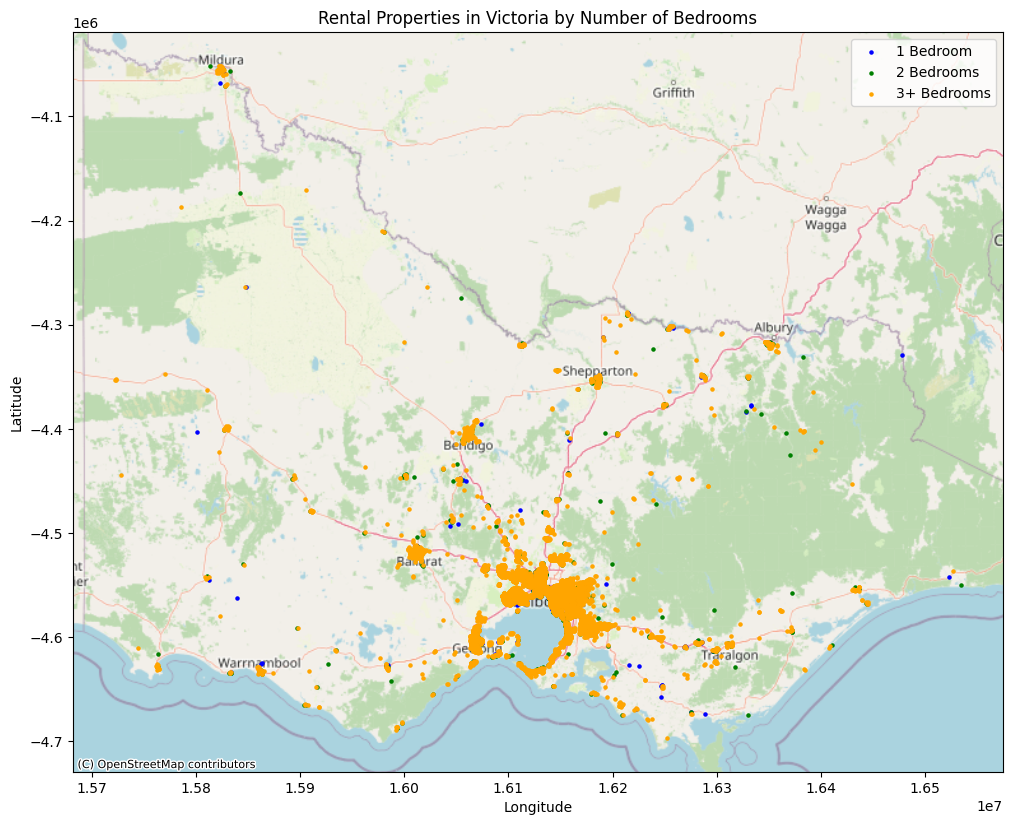

In [74]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx  # For adding OpenStreetMap base tiles


df = pd.read_parquet('../data/curated/map_features.parquet/')


df['beds'] = pd.to_numeric(df['beds'], errors='coerce')

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

# Reproject the GeoDataFrame to Web Mercator (EPSG:3857)
gdf = gdf.to_crs(epsg=3857)


fig, ax = plt.subplots(figsize=(12, 10))

# Define color for each room category
colors = {1: 'blue', 2: 'green', 3: 'orange'}

# Plot properties with 1 room in blue
gdf[gdf['beds'] == 1].plot(ax=ax, marker='o', color=colors[1], markersize=5, label='1 Bedroom')

# Plot properties with 2 rooms in green
gdf[gdf['beds'] == 2].plot(ax=ax, marker='o', color=colors[2], markersize=5, label='2 Bedrooms')

# Plot properties with 3 or more rooms in orange
gdf[gdf['beds'] >= 3].plot(ax=ax, marker='o', color=colors[3], markersize=5, label='3+ Bedrooms')

# Add OpenStreetMap base map for context
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)


plt.title('Rental Properties in Victoria by Number of Bedrooms')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Save the plot to a PNG file (optional)
# output_image_path = "../data/plots/rental_properties_by_rooms_map.png"
# plt.savefig(output_image_path, dpi=300)
# print(f"Map saved as PNG: {output_image_path}")

# Display the plot
plt.show()


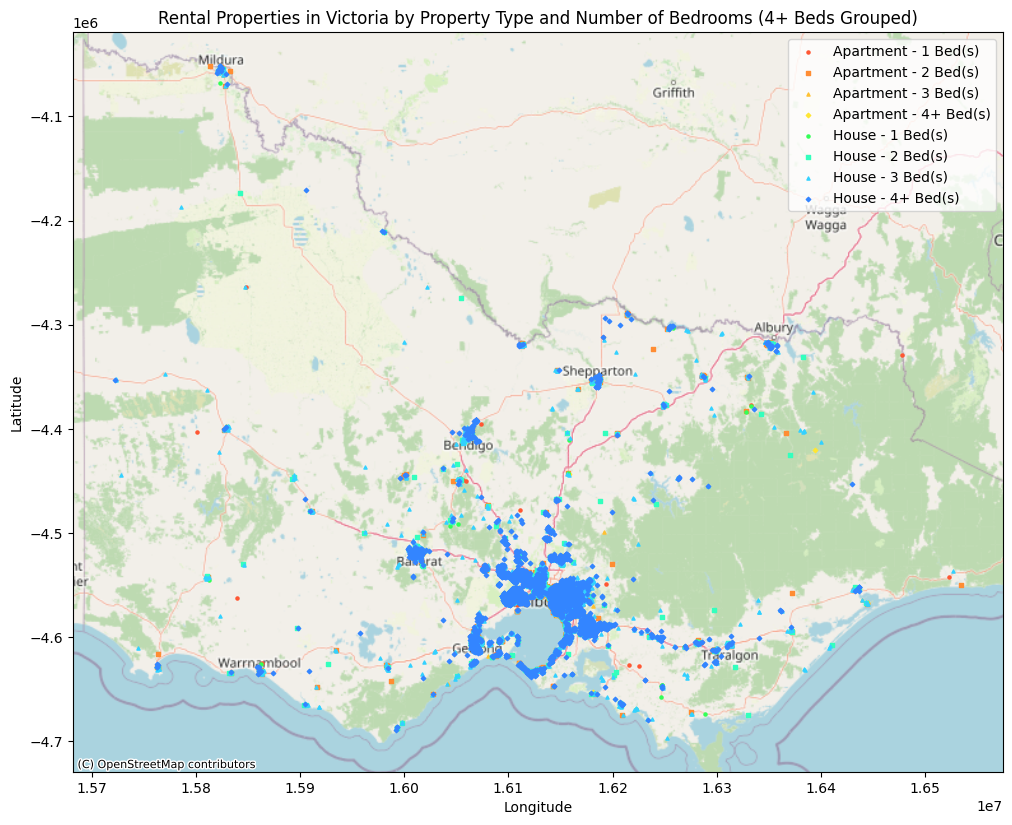

In [84]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx  # For adding OpenStreetMap base tiles
import numpy as np

# Load the properties data (replace with your file)
df = pd.read_parquet('../data/curated/map_features.parquet')

# Convert 'beds' to numeric and filter out properties with 0 beds
df['beds'] = pd.to_numeric(df['beds'], errors='coerce')
df = df[df['beds'] > 0]  # Remove properties with 0 beds

# Generalize beds to 4+ for bed counts greater than 4
df['beds_grouped'] = df['beds'].apply(lambda x: '4+' if x >= 4 else x)

# Generalize property types into 'Apartments' and 'Houses'
apartment_keywords = ['Apartment', 'New Apartments', 'Flat']
df['property_type_grouped'] = df['property_type'].apply(lambda x: 'Apartment' if any(keyword in x for keyword in apartment_keywords) else 'House')

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

# Reproject the GeoDataFrame to Web Mercator (EPSG:3857), which is required for most web tile services
gdf = gdf.to_crs(epsg=3857)

# Define unique colors for each combination of property type and bed count
color_map = {
    ('Apartment', 1): '#FF5733',  # Red for 1-bed apartments
    ('Apartment', 2): '#FF8D33',  # Orange for 2-bed apartments
    ('Apartment', 3): '#FFC133',  # Yellow for 3-bed apartments
    ('Apartment', '4+'): '#FFE633',  # Light Yellow for 4+ bed apartments
    ('House', 1): '#33FF57',  # Green for 1-bed houses
    ('House', 2): '#33FFBD',  # Cyan for 2-bed houses
    ('House', 3): '#33D1FF',  # Blue for 3-bed houses
    ('House', '4+'): '#3385FF'  # Dark Blue for 4+ bed houses
}

# Create a list of marker symbols for beds
marker_symbols = {1: 'o', 2: 's', 3: '^', '4+': 'D'}

# Plot the properties on the map
fig, ax = plt.subplots(figsize=(12, 10))

# Loop through each unique property type and bed group
for (property_type, bed_type), color in color_map.items():
    gdf_filtered = gdf[(gdf['property_type_grouped'] == property_type) & (gdf['beds_grouped'] == bed_type)]
    
    # Only plot if there are properties with the current property type and bed type
    if not gdf_filtered.empty:
        marker_symbol = marker_symbols[bed_type]  # Assign a unique marker for each bed type
        
        gdf_filtered.plot(
            ax=ax,
            marker=marker_symbol,
            color=color,
            markersize=5,
            label=f"{property_type} - {bed_type} Bed(s)"
        )

# Add OpenStreetMap base map for context
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Add title, labels, and legend
plt.title('Rental Properties in Victoria by Property Type and Number of Bedrooms (4+ Beds Grouped)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Display the plot
plt.show()


In [86]:
df = spark.read.parquet('../data/landing/combined_data_with_geolocation.parquet', header=True, inferSchema=True)
#df.show()

df = df.withColumnRenamed("School_Count", "Number of Schools")
df = df.withColumnRenamed("groceries_Count", "Number of Groceries")
df = df.withColumnRenamed("hc_Count", "Number of Healthcare Services")
df = df.withColumnRenamed("Postcode", "postcode")
df = df.withColumnRenamed("Postcode_Name", "suburbs")
df
# Convert Spark DataFrame to Pandas for plotting
df_pandas = df.toPandas()


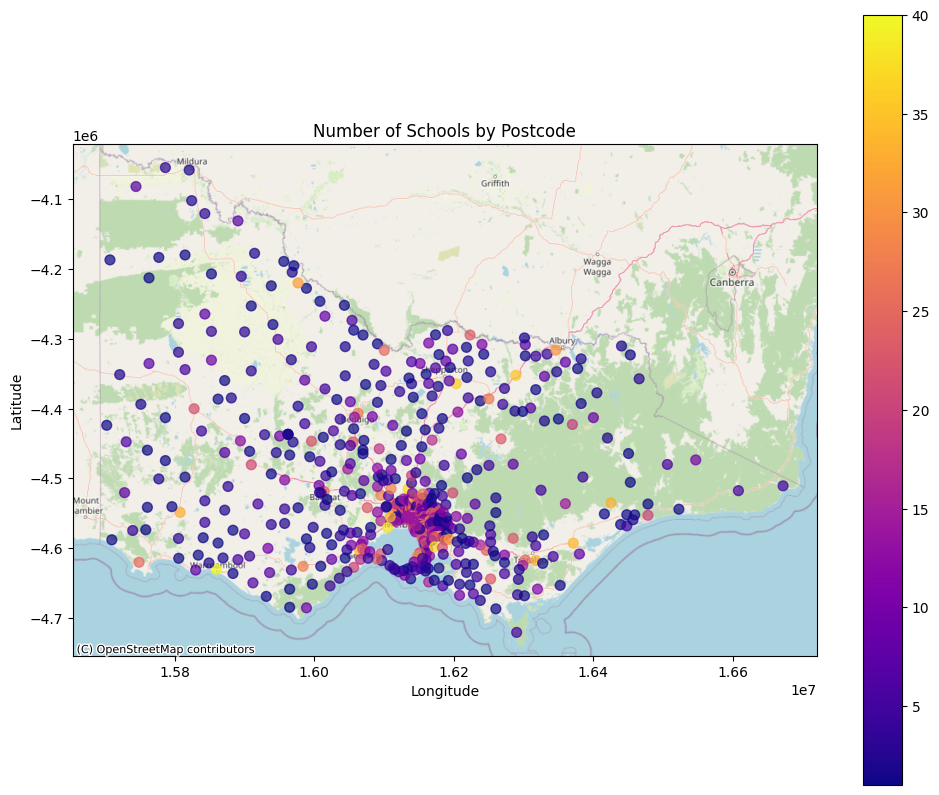

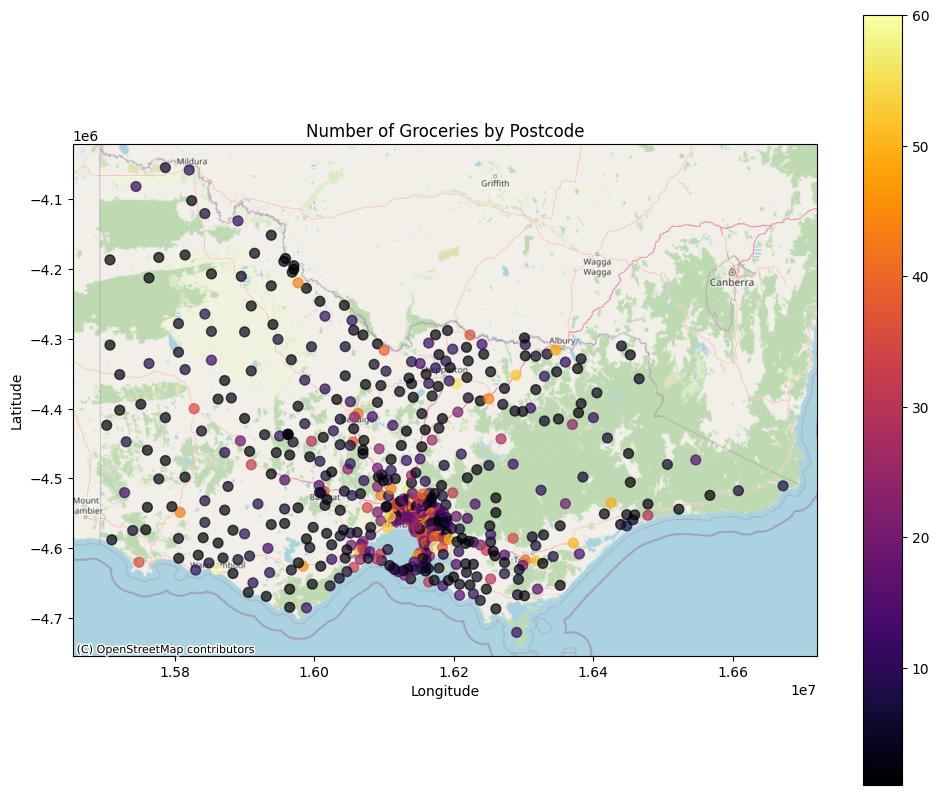

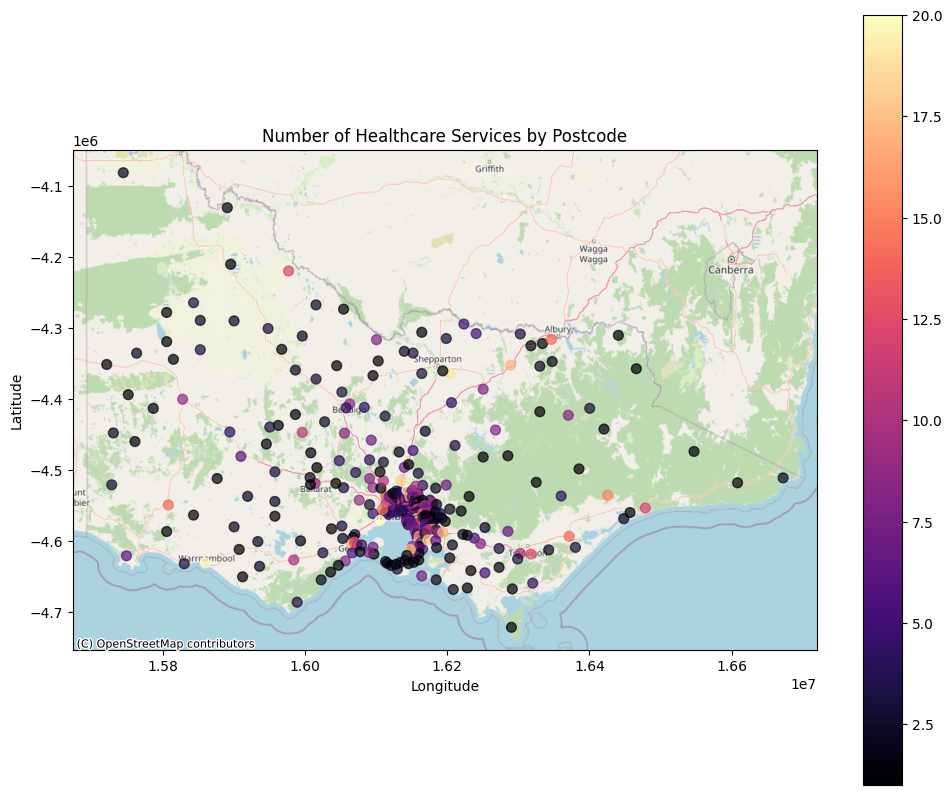

In [88]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Convert the Pandas DataFrame to a GeoDataFrame using longitude and latitude
gdf = gpd.GeoDataFrame(df_pandas, geometry=gpd.points_from_xy(df_pandas['Longitude'], df_pandas['Latitude']))

# Set the CRS to EPSG:4326 (WGS 84, commonly used for geographic coordinates)
gdf.set_crs(epsg=4326, inplace=True)

# Reproject to Web Mercator (EPSG:3857) for plotting on a basemap
gdf = gdf.to_crs(epsg=3857)

# Plotting the number of schools with a vibrant colormap
fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(ax=ax, column='Number of Schools', cmap='plasma', legend=True, markersize=50, alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title('Number of Schools by Postcode')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Plotting the number of groceries with a vibrant colormap
fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(ax=ax, column='Number of Groceries', cmap='inferno', legend=True, markersize=50, alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title('Number of Groceries by Postcode')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Plotting the number of healthcare services with a vibrant colormap
fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(ax=ax, column='Number of Healthcare Services', cmap='magma', legend=True, markersize=50, alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title('Number of Healthcare Services by Postcode')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
